# Plotting Scripts
Copyright (c) 2025 University of Salerno SPDX-License-Identifier: Apache-2.0

Run this whole Jupyter to produce the paper plots.

### Initialization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from rdkit import Chem
import os
import re
import networkx as nx
from tqdm import tqdm
import subprocess
import signal
import glob

sns.set_theme(style="whitegrid")

SINGLE_COL_FIGSIZE=(7, 5)
HALF_COL_FIGSIZE=(3.5, 5)

In [ ]:
# time in ms, memory in bytes
class SIGMOParser:
  def __init__(self, out, err = ''):
    if err:
      self.candidates_sizes = []
      self._parseNumCandidates(err)
    self.n_refinement_steps = 0
    self._lines = [line.strip() for line in out.split('\n')]
    self.parse()
  
  def _parseMemory(self, value, unit):
    value = float(value)
    if unit == 'B':
      return value
    elif unit == 'KB':
      return value * 1024
    elif unit == 'MB':
      return value * 1024 * 1024
    elif unit == 'GB':
      return value * 1024 * 1024 * 1024
  
  def _parseGPUStats(self, start):
    for i in range(1, 6):
      line = self._lines[start + i]
      if line.startswith('Data signature time'):
        self.data_signature_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Query signature time'):
        self.query_signature_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Filter time'):
        self.filter_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Join time'):
        self.join_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Total time:'):
        self.total_gpu_time = int(line.split(' ')[-2])
      
  def _parseConfigs(self, start):
    for i in range(1, 5):
      line = self._lines[start + i]
      if line.startswith('Filter domain'):
        self.filter_domain = line.split(' ')[-1]
      elif line.startswith('Filter Work Group Size'):
        self.filter_work_group_size = int(line.split(' ')[-1])
      elif line.startswith('Join Work Group Size'):
        self.join_work_group_size = int(line.split(' ')[-1])
      elif line.startswith('Find all'):
        self.find_all = line.split(' ')[-1] == 'Yes'

  def _parseHostStats(self, start):
    for i in range(1, 6):
      line = self._lines[start + i]
      if line.startswith('Setup Data time'):
        self.setup_data_host_time = int(line.split(' ')[3])
      elif line.startswith('Filter time'):
        self.filter_host_time = int(line.split(' ')[-2])
      elif line.startswith('Mapping time'):
        self.mapping_host_time = int(line.split(' ')[-2])
      elif line.startswith('Join time'):
        self.join_host_time = int(line.split(' ')[-2])
      elif line.startswith('Total time:'):
        self.total_time = int(line.split(' ')[-2])
  
  def _parseNumCandidates(self, err):
    for line in err.split('\n'):
      if line.startswith('Node'):
        self.candidates_sizes.append(int(line.split(' ')[-1]))
  
  def parse(self):
    for i, line in enumerate(self._lines):
      if line.startswith('# Query Nodes'):
        self.n_query_nodes = int(line.split(' ')[-1])
      elif line.startswith('# Query Graphs'):
        self.n_query_graphs = int(line.split(' ')[-1])
      elif line.startswith('# Data Nodes'):
        self.n_data_nodes = int(line.split(' ')[-1])
      elif line.startswith('# Data Graphs'):
        self.n_data_graphs = int(line.split(' ')[-1])
      elif "Configs" in line:
        self._parseConfigs(i)
      elif line.endswith('B for graph data'):
        self.graph_data_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for query data'):
        self.query_data_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for candidates'):
        self.candidates_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for data signatures'):
        self.data_signatures_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for query signatures'):
        self.query_signatures_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.startswith('Total allocated memory'):
        self.total_memory = self._parseMemory(line.split(' ')[3], line.split(' ')[4])
      elif line.startswith('# Total candidates:'):
        self.n_total_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Average candidates:'):
        self.n_avg_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Median candidates:'):
        self.n_median_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Zero candidates:'):
        self.n_zero_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Matches:'):
        self.n_matches = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('[*] Refinement step'):
        self.n_refinement_steps = int(line.split(' ')[-1].replace(':', ''))
      elif "Overall GPU Stats" in line:
        self._parseGPUStats(i)
      elif "Overall Host Stats" in line:
        self._parseHostStats(i)
      elif line.startswith("Node 0:"):
        self._parseNumCandidates(i)
  
  def get_df_str(self):
    header = []
    vals = []
    for key, value in sorted(self.__dict__.items(), key=lambda x: x[0]):
      if key.startswith('_'):
        continue
      header.append(key)
      if key == 'candidates_sizes':
        v = '-'.join([str(x) for x in value])
        vals.append(v)
      else:
        vals.append(str(value))
    return header, vals

  def get_df_headers(self):
    return list(sorted(self.__dict__.keys()))
      

# Create a function to set the font size for specific figures
def set_font_size(ax, size):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)

## Section 5 (Experimental Evaluation)

### Read Results

In [9]:
headers = []
vals = []

output_files = sorted(glob.glob('./out/SIGMO/logs/core/sigmo*.log'))
error_files = sorted(glob.glob('./out/SIGMO/logs/core/err*.log'))

for (o, e) in zip(output_files, error_files):
  with open(o, 'r') as f:
    out = f.read()
  with open(e, 'r') as f:
    err = f.read()
  out = SIGMOParser(out, err)
  if len(headers) == 0:
    headers = out.get_df_str()[0]
  vals.append(out.get_df_str()[1])

df = pd.DataFrame(columns=headers)
for val in vals:
  df.loc[len(df)] = val
df = df.sort_values(by='n_refinement_steps')

df.to_csv('./out/SIGMO/sigmo_results.csv', index=False)
del df, headers, vals

In [11]:
sigmo_df = pd.read_csv('./out/SIGMO/sigmo_results.csv')
sigmo_df = sigmo_df.sort_values(by='n_refinement_steps')

### Figure 5
Summary of the distribution of candidate set sizes for each refinement iteration. The box represents the distribution of the candidates set sizes for each node and aligns with the left axis, whereas the line indicates the total number of candidates, aligning with the right axis.

In [11]:

candidates_sizes = sigmo_df[sigmo_df['find_all']]['candidates_sizes']
# Convert strings into numeric arrays (Nodes × Iterations)
candidate_matrix = np.array(candidates_sizes.apply(lambda x: [int(i) for i in x.split('-')]).tolist()).T

data_for_scatter = pd.DataFrame({
    'Iteration': np.tile(np.arange(candidate_matrix.shape[1]), candidate_matrix.shape[0]),
    'Node': np.repeat(np.arange(candidate_matrix.shape[0]), candidate_matrix.shape[1]),
    'CandidateSize': candidate_matrix.flatten()
})
data_for_scatter['Iteration'] += 1

/tmp/ipykernel_2559805/2499918045.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = data_for_scatter.groupby('Iteration', group_keys=False).apply(find_outliers)


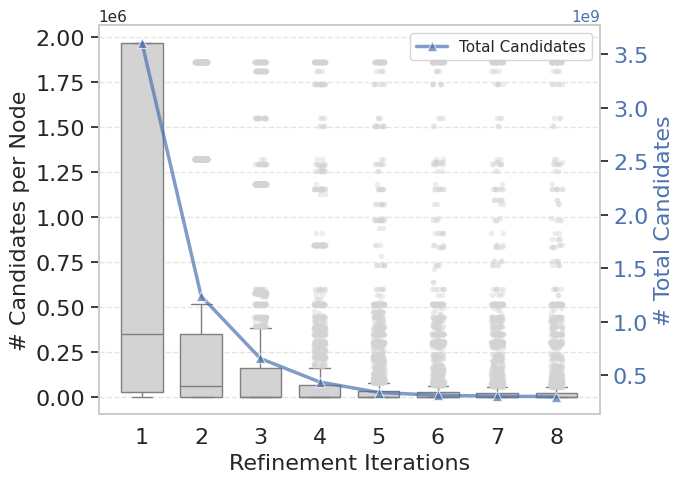

In [12]:
FONTSIZE = 16
COLOR=sns.color_palette()[0]
fig, ax1 = plt.subplots(figsize=SINGLE_COL_FIGSIZE)

# Function to get outliers
def find_outliers(group):
    values = group['CandidateSize']
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(values < lower) | (values > upper)]

outliers_df = data_for_scatter.groupby('Iteration', group_keys=False).apply(find_outliers)

sns.boxplot(data=data_for_scatter, 
            x='Iteration', 
            y='CandidateSize', 
            flierprops=dict(marker='.', markersize=4), 
            ax=ax1, 
            color="lightgray",
            width=0.7,
            showfliers=False,
            )
sns.stripplot(
    data=outliers_df,
    x='Iteration',
    y='CandidateSize',
    ax=ax1,
    jitter=True,
    size=4,
    color='lightgray',
    alpha=0.4
)

ax1.set_xlabel('Refinement Iterations', fontsize=FONTSIZE)
ax1.set_ylabel('# Candidates per Node', fontsize=FONTSIZE)
set_font_size(ax1, FONTSIZE)

# Secondary axis for the total sum of candidates per iteration
ax2 = ax1.twinx()
total_candidates = data_for_scatter.groupby('Iteration')['CandidateSize'].sum().reset_index()

sns.lineplot(data=total_candidates['CandidateSize'], ax=ax2, marker='^', linestyle='-', label='Total Candidates', linewidth=2.5, markersize=7, alpha=.7, color=COLOR)
ax2.set_ylabel('# Total Candidates', fontsize=FONTSIZE, color=COLOR)
ax2.tick_params(axis='y', labelcolor=COLOR)
set_font_size(ax2, FONTSIZE)
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
# ax2.grid(True, axis='y', linestyle='--', alpha=0.5, color=sns.color_palette()[0])
ax2.grid(False)

fig.tight_layout()
fig.savefig('./out/plots/candidates_size.pdf')
fig.show()

### Figure 6
Comparison of filter and join time per each refinement iteration on the entire dataset.

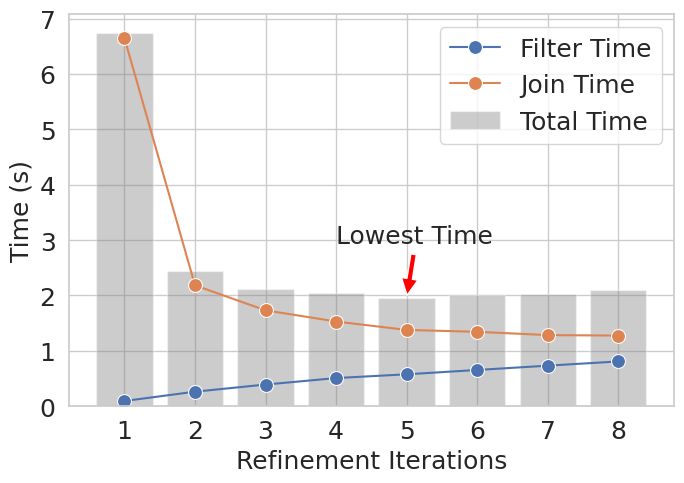

In [10]:
FONTSIZE = 18
fig, axs = plt.subplots(figsize=SINGLE_COL_FIGSIZE)

filter_time = [result.filter_gpu_time / 1000 for result in sigmo_df[sigmo_df['find_all']].itertuples()]
join_time = [result.join_gpu_time / 1000 for result in sigmo_df[sigmo_df['find_all']].itertuples()]
total_time = [result.total_gpu_time / 1000 for result in sigmo_df[sigmo_df['find_all']].itertuples()]

# Create a DataFrame
iterations = list(range(1, len(filter_time) + 1))
data = pd.DataFrame({
    'Iterations': iterations,
    'Filter Time': filter_time,
    'Join Time': join_time
})

# Calculate total time
data['Total Time'] = total_time

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Iterations', value_vars=['Filter Time', 'Join Time'], var_name='Type', value_name='Time')


# Create the line plot
sns.lineplot(data=data_melted, x='Iterations', y='Time', hue='Type', marker='o', markersize=10, ax=axs)

# Add the total time bars
axs.bar(data['Iterations'], data['Total Time'], color='gray', alpha=0.4, label='Total Time')

# Add labels and title
axs.set_xlabel('Refinement Iterations')
axs.set_ylabel('Time (s)')

# get the lowest bar and add a label to mark that is the lowest, add also an arrow
lowest_bar = min(data['Total Time'])
axs.annotate('Lowest Time', xy=(data['Iterations'][data['Total Time'].idxmin()], lowest_bar),
             xytext=(data['Iterations'][data['Total Time'].idxmin()] - 1, lowest_bar + lowest_bar * .5),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=FONTSIZE)


# Add legend
axs.legend(fontsize=FONTSIZE)
set_font_size(axs, 18)

# Show the plot
fig.tight_layout()
fig.savefig('./out/plots/filter_join_time.pdf', dpi=300)
fig.show()

### Figure 7
Total execution time of SIGMo across refinement iterations, grouped by query graph diameter

In [23]:
diameter_res = {}
for file in glob.glob('./out/SIGMO/logs/diameter/*.log'):
  diameter, iteration = file.split('/')[-1].replace('.log', '').replace('sigmo_d', '').split('_')
  if diameter not in diameter_res:
    diameter_res[diameter] = []
  with open(file, 'r') as f:
    content = f.read()
  diameter_res[diameter].append((iteration, content))

for d in diameter_res:
  tmp = sorted(diameter_res[d], key=lambda x: int(x[0]))
  diameter_res[d] = [x[1] for x in tmp]

# sort the diameter_res by diameter
diameter_res = dict(sorted(diameter_res.items(), key=lambda x: int(x[0])))


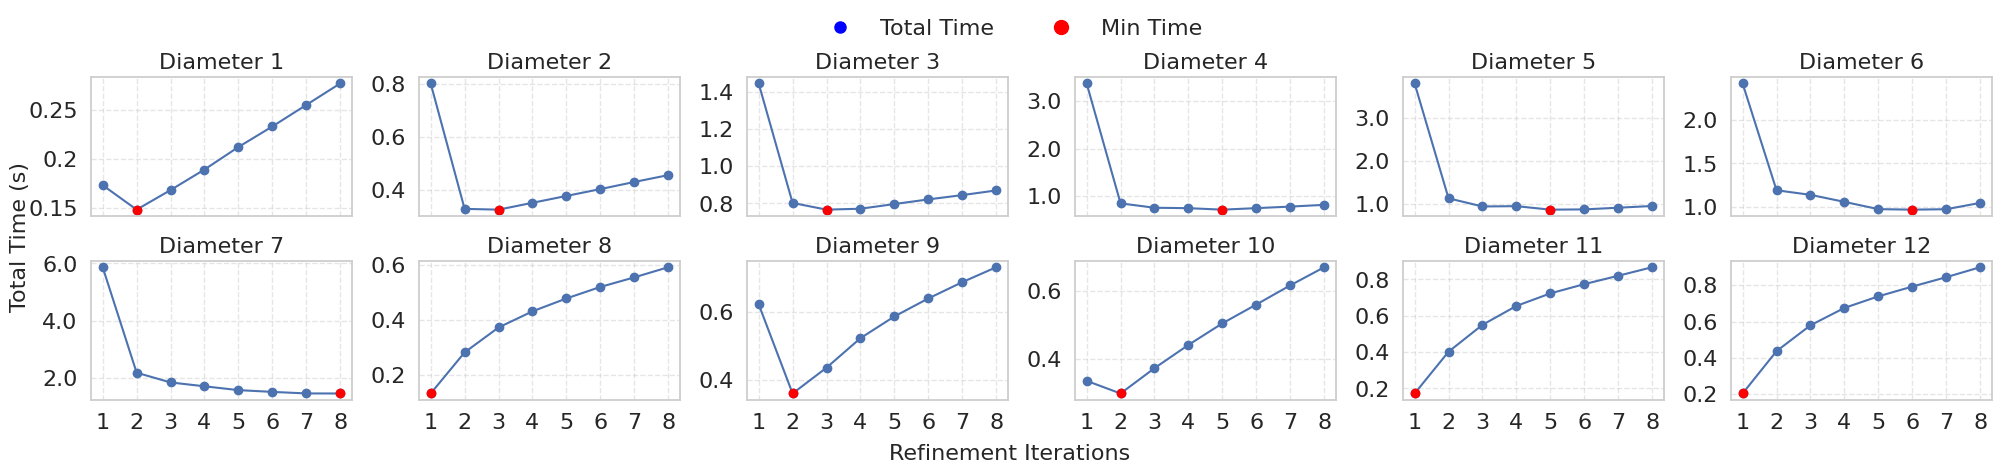

In [24]:
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

FONTSIZE = 16
LAST_ITERATION=8
fig, axs = plt.subplots(2, len(diameter_res) // 2, figsize=(20, 4.5), sharex=True, sharey=False)

if len(diameter_res) == 1:
  axs = [axs]  # Ensure axs is iterable when there's only one plot

def format_ticks(value, _):
    return f'{value:.2}'  # Format to 3 significant digits


for idx, (diameter, results) in enumerate(diameter_res.items()):
  total_times = []
  for output in results:
    parser = SIGMOParser(output)
    total_times.append(parser.total_time / 1000)  # Convert ms to seconds

  iterations = list(range(1, LAST_ITERATION + 1))
  total_times = total_times[:len(iterations)]
  axs.flat[idx].plot(iterations, total_times, marker='o')
  # Highlight the minimum time in red
  min_time = min(total_times)
  min_index = total_times.index(min_time) + (1 if diameter != 4 else 0)  # Add 1 to match iteration index
  axs.flat[idx].plot(min_index, min_time, marker='o', color='red')
  
  # Set x-ticks for all subplots
  axs.flat[idx].set_xticks(iterations)
  axs.flat[idx].grid(True, linestyle='--', alpha=0.5)
  axs.flat[idx].set_title(f'Diameter {diameter}', fontsize=FONTSIZE)
  
  # Apply the y-tick formatter
  axs.flat[idx].yaxis.set_major_formatter(FuncFormatter(format_ticks))
  set_font_size(axs.flat[idx], FONTSIZE)

# Adjust spacing between horizontal plots
plt.subplots_adjust(wspace=0.3)  # Increase the vertical space between rows

handles = [
    Line2D([0], [0], marker='o', color='blue', label='Total Time', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='o', color='red', label='Min Time', markersize=10, linestyle='None')
]
fig.legend(handles=handles, loc='upper center', fontsize=FONTSIZE, ncol=2, bbox_to_anchor=(0.5, 1.03), frameon=False)
# Add a single x-axis label
fig.text(0.5, 0.005, 'Refinement Iterations', ha='center', fontsize=FONTSIZE)
# Add a single y-axis label
fig.text(0.00, 0.5, 'Total Time (s)', va='center', rotation='vertical', fontsize=FONTSIZE)

fig.tight_layout(rect=[0, 0.025, 1, 0.95])
fig.savefig('./out/plots/total_time_per_diameter.pdf', dpi=300)
fig.show()

### Figure 8
Profiling of the NVIDIA V100S GPU occupancy during the SIGMo runtime with six refinement iterations.

In [ ]:
PROFILING_SAMPLE = 10 # ms
def extract_profiled_region(X, Y, time_per_sample, left_padding_ms=500, right_padding_ms=100):
    X = np.array(X)

    # Find the first and last nonzero indices
    nonzero_indices = np.where(X > 0)[0]
    if len(nonzero_indices) == 0:
        raise ValueError("No nonzero profiling data found in X.")

    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1] + 1  # Include the last nonzero element

    # Extract the active region
    active_region = X[start_idx:end_idx]

    # Determine number of samples for Y milliseconds
    num_samples = int(Y / time_per_sample)
    left_padding_samples = int(left_padding_ms / time_per_sample)
    right_padding_samples = int(right_padding_ms / time_per_sample)

    # if num_samples > len(active_region):
    #     raise ValueError("Y exceeds the available profiled region.")

    # Define padded start and end indices
    padded_start = max(0, start_idx - left_padding_samples)
    padded_end = min(len(X), start_idx + num_samples + right_padding_samples)

    return X[padded_start:padded_end]

with open('./out/SIGMO/logs/gpu_metrics/dcgmi.log', 'r') as f:
  dcgmi_output = f.read()

with open('./out/SIGMO/logs/gpu_metrics/sigmo.log', 'r') as f:
  sigmo_output = f.read()

# Parse the dcgmi output into a DataFrame
data = [line for line in dcgmi_output.strip().split("\n") if len(line.split()) > 2]  # Extract rows

gpu_utilization = [float(row.split()[2]) for row in data]  

# Print the DataFrame (optional)
p = SIGMOParser(sigmo_output)
gpu_utilization = extract_profiled_region(gpu_utilization, p.total_time, PROFILING_SAMPLE, 200, 100)

gpu_df = pd.DataFrame()

# Add a time column (assuming each row corresponds to 10 ms)
gpu_df['timestamp'] = [i * PROFILING_SAMPLE for i in range(len(gpu_utilization))]
gpu_df['gpu_util'] = gpu_utilization
gpu_df['gpu_util'] = gpu_df['gpu_util'] * 100
gpu_df.to_csv('./out/SIGMO/gpu_util.csv', index=False)

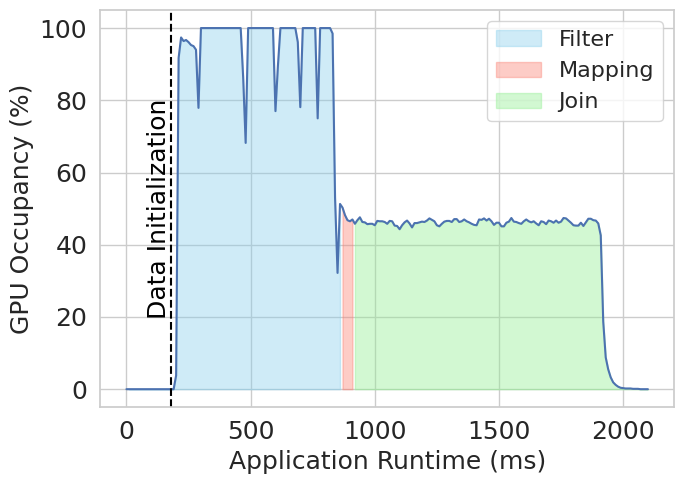

In [ ]:
FONTSIZE = 18 
OFFSET = 140

fig, axs = plt.subplots(figsize=SINGLE_COL_FIGSIZE)

operations = [
    {'name': 'Filter', 'start': p.setup_data_host_time , 'end': (p.setup_data_host_time + p.filter_gpu_time) +OFFSET, 'color': 'skyblue'},
    {'name': 'Mapping', 'start': (p.setup_data_host_time + p.filter_gpu_time ) + OFFSET, 'end': (p.setup_data_host_time + p.filter_gpu_time + p.mapping_host_time) + OFFSET + 20, 'color': 'salmon'},
    {'name': 'Join', 'start': (p.setup_data_host_time + p.filter_gpu_time + p.mapping_host_time + OFFSET + 20), 'end': (p.setup_data_host_time + p.filter_host_time + p.mapping_host_time + p.join_host_time), 'color': 'lightgreen'},
    # {'name': 'Other', 'start': (p.setup_data_host_time + p.filter_host_time + p.mapping_host_time + p.join_host_time), 'end': p.total_time, 'color': 'lightgray'}
]

# Plot the GPU utilization as a line
sns.lineplot(data=gpu_df, x='timestamp', y='gpu_util', ax=axs)

# Loop through each operation to fill the corresponding region with its color
for op in operations:
    # Create a mask for timestamps within the operation's interval
    mask = (gpu_df['timestamp'] >= op['start']) & (gpu_df['timestamp'] <= op['end'])
    
    # Fill the area under the curve for this operation
    axs.fill_between(
        gpu_df.loc[mask, 'timestamp'], 
        gpu_df.loc[mask, 'gpu_util'], 
        color=op['color'], 
        alpha=0.4, 
        label=op['name']
    )

# Find the first and last nonzero GPU utilization timestamps
nonzero_mask = gpu_df['gpu_util'] > 0
if nonzero_mask.any():
    first_nonzero_ts = gpu_df.loc[nonzero_mask, 'timestamp'].iloc[0] - 20
    last_nonzero_ts = gpu_df.loc[nonzero_mask, 'timestamp'].iloc[-1]
    
    # Draw vertical dashed lines at the first and last nonzero values
    axs.axvline(first_nonzero_ts, color='black', linestyle='--')

    # Get overall min and max timestamps from the data
    min_ts = gpu_df['timestamp'].min()
    max_ts = gpu_df['timestamp'].max()
    
    # Highlight regions before the first nonzero and after the last nonzero
    axs.text(first_nonzero_ts, .5, 'Data Initialization', transform=axs.get_xaxis_transform(), 
             rotation=90, verticalalignment='center', horizontalalignment='right', color='black', fontsize=FONTSIZE)

# Add labels and title
axs.set_xlabel("Application Runtime (ms)", fontsize=14)
axs.set_ylabel("GPU Occupancy (%)", fontsize=FONTSIZE)
axs.grid(True)
axs.legend(fontsize=FONTSIZE-2)
set_font_size(axs, FONTSIZE)

fig.tight_layout()
fig.savefig('./out/plots/gpu_utilization.pdf')
fig.show()

### Figure 9
Instruction Roofline of SIGMo execution with six refinement iterations on NVIDIA V100S.

In [ ]:
metrics_df = pd.read_csv('./out/SIGMO/logs/gpu_metrics/metrics.csv')

kernels = ['FilterCandidatesKernel', 'RefineCandidatesKernel', 'JoinCandidatesKernel', 'generateGMCR']

# drop nan kernel names
metrics_df = metrics_df[~metrics_df['Kernel Name'].isna()]

# keep only entries that have in the column Kernel Name at least one of the kernels
metrics_df = metrics_df[metrics_df['Kernel Name'].str.contains('|'.join(kernels))]

for substring, new_name in zip(kernels, ['Filter', 'Filter', 'Join', 'Mapping']):
  metrics_df.loc[metrics_df['Kernel Name'].str.contains(substring), 'Kernel Name'] = new_name



In [ ]:
groups = metrics_df.groupby(['ID','Kernel Name'])
group_names = groups.groups.keys()

def fetch_metric_unit(df, metric):
  return float(df.loc[df['Metric Name'] == metric]['Metric Value'].values[0].replace(',', '')), df.loc[df['Metric Name'] == metric]['Metric Unit'].values[0]

def parse_memory(val, unit):
  if unit == 'Kbyte':
    return float(val) * 1024
  elif unit == 'Mbyte':
    return float(val) * 1024 ** 2
  elif unit == 'Gbyte':
    return float(val) * 1024 ** 3
  else:
    return float(val)

def parse_time(val, unit):
  if unit == 'msecond':
    return float(val) / 1000
  elif unit == 'usecond':
    return float(val) / 1000 ** 2
  elif unit == 'nsecond':
    return float(val) / 1000 ** 3
  else:
    return float(val)

metrics_refined_df = pd.DataFrame(columns=['kernel', 'ii_global', 'it'])

for name, g in groups:
  instructions = int(g.loc[g['Metric Name'] == "inst_executed"]['Metric Value'].values[0].replace(',', ''))
  
  total_bytes = 0
  total_bytes += fetch_metric_unit(g, "dram__sectors_read.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "dram__sectors_write.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "lts__t_sectors.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "lts__t_sectors_data_ecc.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "lts__t_sectors_srcunit_tex.sum")[0] * 32
  # total_bytes += fetch_metric_unit(g, "l1tex__m_l1tex2xbar_write_sectors_mem_lg_op_st.sum")[0] * 32
  # total_bytes += fetch_metric_unit(g, "l1tex__m_xbar2l1tex_read_sectors_mem_lg_op_ld.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_lsu_mem_global_op_atom.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_lsu_mem_global_op_ld.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_lsu_mem_global_op_st.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_lsu_mem_local_op_ld.sum")[0] * 32
  total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_lsu_mem_local_op_st.sum")[0] * 32
  # total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_tex_mem_surface_op_ld.sum")[0] * 32
  # total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_tex_mem_surface_op_red.sum")[0] * 32
  # total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_tex_mem_surface_op_st.sum")[0] * 32
  # total_bytes += fetch_metric_unit(g, "l1tex__t_sectors_pipe_tex_mem_texture.sum")[0] * 32
  
  instruction_intensity_global = instructions / (total_bytes)
  
  time = parse_time(float(g.loc[g['Metric Name'] == "gpu__time_duration.sum"]['Metric Value'].values[0]), g.loc[g['Metric Name'] == "gpu__time_duration.sum"]['Metric Unit'].values[0])
  
  instruction_throughput = (instructions / time) / 1e9
  if instruction_throughput < 1: continue
  print(f"{name=}\t{total_bytes=}\t{time=:.4f}\t{instructions=:12}\t{instruction_intensity_global=}\t{instruction_throughput=}")
  metrics_refined_df.loc[len(metrics_refined_df)] = [name[1], instruction_intensity_global, instruction_throughput]


name=('12', 'Filter')	total_bytes=15568915904.0	time=0.1264	instructions= 32344366170	instruction_intensity_global=2.077496363230404	instruction_throughput=255.94972042415128
name=('15', 'Filter')	total_bytes=14788537856.0	time=0.1075	instructions= 27416097463	instruction_intensity_global=1.8538747866731633	instruction_throughput=254.93860389622463
name=('18', 'Filter')	total_bytes=14402323936.0	time=0.0995	instructions= 25264815510	instruction_intensity_global=1.754217973590231	instruction_throughput=253.79021104972375
name=('19', 'Mapping')	total_bytes=16695669184.0	time=0.0155	instructions=   923157551	instruction_intensity_global=0.05529323448051377	instruction_throughput=59.44349974243401
name=('21', 'Mapping')	total_bytes=17721395136.0	time=0.0157	instructions=   922972087	instruction_intensity_global=0.0520823603286761	instruction_throughput=58.93819201787995
name=('22', 'Join')	total_bytes=254857146496.0	time=0.3478	instructions= 57094178828	instruction_intensity_global=0.22402

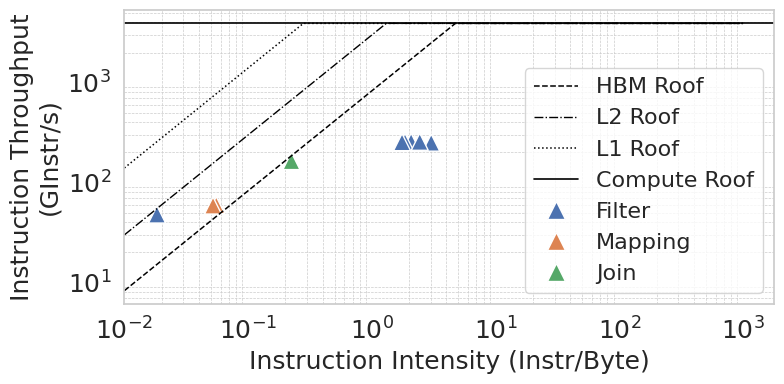

In [ ]:
FONTSIZE = 18
fig, axs = plt.subplots(figsize=(8, 4))

peak = 80 * 32 * 2 * 1.53 # GFLOP/s
peak_nofma = peak / 2 # GFLOP/s
l1_peak = 437.5 * 32 # GB/s
l2_peak = 93.6 * 32 # GB/s
hbm_peak = 25.9 * 32 # GB/s

# ==== PLOTTING SECTION ====
# Create log-space x-axis for roofline curves
x_vals = np.logspace(-2, 3, 500)

# Compute memory ceilings (sloped lines)
roof_hbm = np.minimum(hbm_peak * x_vals, peak_nofma)
roof_l2 = np.minimum(l2_peak * x_vals, peak_nofma)
roof_l1 = np.minimum(l1_peak * x_vals, peak_nofma)

# Plot sloped memory rooflines
axs.plot(x_vals, roof_hbm, linestyle='--', color='black', label="HBM Roof", linewidth=1.1)
axs.plot(x_vals, roof_l2, linestyle='-.', color='black', label="L2 Roof", linewidth=1)
axs.plot(x_vals, roof_l1, linestyle='dotted', color='black', label="L1 Roof", linewidth=1.1)

# Plot flat compute peak
axs.axhline(y=peak_nofma, color='black', linestyle='-', label="Compute Roof", linewidth=1.2)

instruction_intensity = metrics_refined_df['ii_global'].values
instruction_throughput = metrics_refined_df['it'].values
kernel_names = metrics_refined_df['kernel'].values

# Plot kernels
sns.scatterplot(data=metrics_refined_df, x="ii_global", y="it", hue="kernel", marker='^', color='black', ax=axs, s=150)
# for i, name in enumerate(kernel_names):
    # plt.annotate(name, (instruction_intensity[i], instruction_throughput[i]), fontsize=9)

# Set log-log scale
axs.set_xscale("log")
axs.set_yscale("log")

# print text values
# axs.text(2, peak_nofma + 500, f"{peak_nofma} Ginstr", fontsize=FONTSIZE-8, color='black')

# Labels and legend
axs.set_xlabel("Instruction Intensity (Instr/Byte)")
axs.set_ylabel("Instruction Throughput\n(GInstr/s)")
axs.grid(True, which="both", linestyle="--", linewidth=0.5)
axs.grid(False)
axs.set_xlim(1e-2, axs.get_xlim()[1])
set_font_size(axs, FONTSIZE)

axs.legend(fontsize=FONTSIZE - 2)
fig.tight_layout()
fig.savefig('./out/plots/roofline.pdf', dpi=300)
fig.show()

### Figure 10
Comparison of SIGMo with other CPU and GPU state-of-the-art subgraph isomorphism frameworks.

In [15]:
sota_df = pd.DataFrame(columns=['benchmark','total_time','first_solution_time','matches',])
benchmarks = ['VF3', 'GSI', 'CuTS']

# get the best result (lowest time for find all) from the sigmo_df
best_result_find_all = min(sigmo_df[sigmo_df['find_all']].itertuples(), key=lambda x: x.total_time)
result_find_first = min(sigmo_df[~sigmo_df['find_all']].itertuples(), key=lambda x: x.total_time)

sota_df.loc[len(sota_df)] = ['SIGMo', best_result_find_all.total_time / 1000, result_find_first.total_time / 1000, best_result_find_all.n_matches]
for b in benchmarks:
  benchmark = b
  total_time = 0
  first_solution_time = 0
  matches = 0
  with open(f'./out/{b}/{b}.txt') as f:
    for line in f:
      if line.startswith('Total time (s):'):
        total_time = float(line.split(' ')[-1])
      elif line.startswith('First match time (s):'):
        first_solution_time = float(line.split(' ')[-1])
      elif line.startswith('Total matches:'):
        matches = int(line.split(' ')[-1].replace(',', ''))
      if first_solution_time == total_time:
        first_solution_time = 0
  sota_df.loc[len(sota_df)] = [benchmark, total_time, first_solution_time, matches]
  
sota_df['throughput'] = sota_df['matches'] / sota_df['total_time']
  

#### Figure 10 (a)
Execution Time

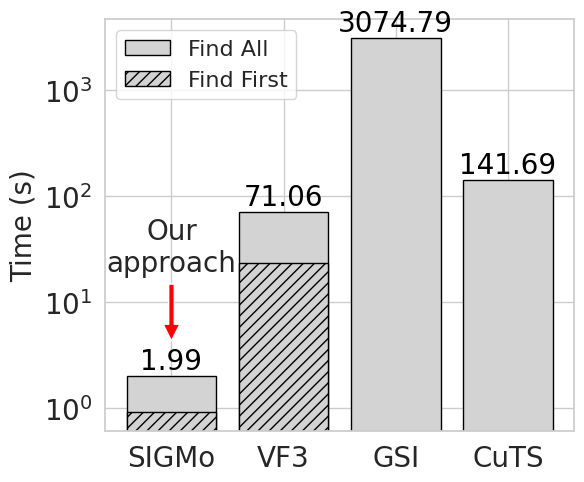

In [16]:
fig, axs = plt.subplots(figsize=(6, 5))
FONTSIZE=20
set_font_size(axs, 20)

axs.bar(sota_df['benchmark'], sota_df['total_time'], color=['lightgray', 'lightgray', 'lightgray'], edgecolor='black')
axs.bar(sota_df['benchmark'], sota_df['first_solution_time'], hatch='///', color=['lightgray', 'lightgray', 'lightgray'], edgecolor='black')

positions = []
for i, row in sota_df.iterrows():
    if row['first_solution_time'] == 0:
        positions.append((i, row['total_time']))

# # Annotate the text only once
# if positions:
#     first_position = positions[0]
#     axs.text(first_position[0] - 1.5, first_position[1] / 12, 
#              'Always find\nall matches', 
#              ha='center', va='bottom',
#              fontsize=FONTSIZE)  # Center the text horizontally and align it vertically at the bottom

#     # Create arrows for all positions
#     for pos in positions:
#         axs.annotate('', 
#                      xy=(pos[0] - .3, pos[1] / 2), 
#                      xytext=(first_position[0] - 1, first_position[1] / 6),  # Point to the same text position
#                      arrowprops=dict(facecolor='black', shrink=0.005))

axs.annotate("Our\napproach", 
             xy=(0, sota_df.loc[0, 'total_time'] + 2), 
             xytext=(0, sota_df.loc[0, 'total_time'] + 15), 
             ha='center', va='bottom',  # Center the text horizontally and align it vertically at the bottom
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=FONTSIZE)

# write the time on top of each bar
for i, row in sota_df.iterrows():
  axs.text(i, row['total_time'] + row['total_time'] * 0.02,
           f'{row["total_time"]:.2f}', 
           ha='center', 
           va='bottom', 
           color='black', 
          #  fontweight='bold',
           fontsize=FONTSIZE
           )

axs.set_yscale('log', base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9])
axs.set_ylabel('Time (s)')
axs.set_xlabel('')

axs.legend(['Find All', 'Find First'], loc='upper left', fontsize=FONTSIZE-4)
fig.tight_layout()
fig.savefig('./out/plots/sota_time.pdf')
fig.show()

#### Figure 10 (b)
Throughput (Matches per second)

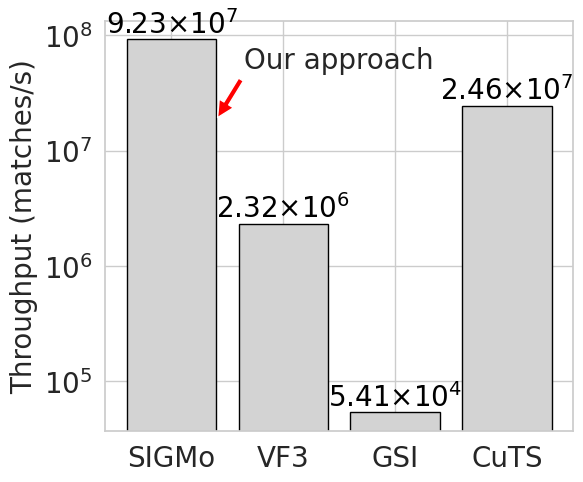

In [17]:
fig, axs = plt.subplots(figsize=(6, 5))
FONTSIZE=20
set_font_size(axs, 20)
axs.bar(sota_df['benchmark'], sota_df['throughput'], color=['lightgray', 'lightgray', 'lightgray'], edgecolor='black')

axs.annotate("Our approach", 
             xy=(0.4, sota_df.loc[0, 'throughput'] - sota_df.loc[0, 'throughput'] * 0.8), 
             xytext=(1.5, sota_df.loc[0, 'throughput'] - sota_df.loc[0, 'throughput'] * 0.5), 
             ha='center', va='bottom',  # Center the text horizontally and align it vertically at the bottom
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=FONTSIZE)

# write the time on top of each bar
for i, row in sota_df.iterrows():
  thorughput_string = f'{row["throughput"]:.2e}'
  a, b = thorughput_string.split('e+0')
  thorughput_string = rf'{a}$\times 10^{b}$'
  # thorughput_string = thorughput_string.replace('e+0', '\nx10^').replace('e+', ' x 10^').replace('e-0', ' / 10^').replace('e-', ' / 10^')
  axs.text(i, row['throughput'] + row['throughput'] * 0.005,
           thorughput_string,
           ha='center', 
           va='bottom', 
           color='black', 
          #  fontweight='bold',
           fontsize=FONTSIZE
           )

axs.set_ylabel('Throughput (matches/s)')
axs.set_xlabel('')
axs.set_yscale('log', base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9])

fig.tight_layout()
fig.savefig('./out/plots/sota_throughput.pdf')
fig.show()

### Figure 11
Filter, join, and total execution times of SIGMo on NVIDIA V100S, AMD MI100, and Intel Max 1100 GPUs. The total time includes an arrow indicating the fastest execution for each GPU.

**Instructions to reproduce**:
1. Execute SIGMo on each hardware;
2. Collect the output csv in the ./out/SIGMO folder, and name each file according to the manufacturer (e.g. sigmo_results_nvidia.csv, sigmo_results_amd.csv, sigmo_results_intel.csv)
3. Run the following cell;

In [ ]:
nvidia_df = pd.read_csv('./out/SIGMO/sigmo_results_nvidia.csv')
amd_df = pd.read_csv('./out/SIGMO/sigmo_results_amd.csv')
amd_df['total_time'] = amd_df['filter_gpu_time'] + amd_df['join_gpu_time']
intel_df = pd.read_csv('./out/SIGMO/sigmo_results_intel.csv')
intel_df['total_time'] = intel_df['filter_gpu_time'] + intel_df['join_gpu_time']


nvidia_df['GPU'] = 'NVIDIA V100S'
amd_df['GPU'] = 'AMD MI100'
intel_df['GPU'] = 'Intel Max 1100'

df = pd.concat([nvidia_df, amd_df, intel_df])
df = df[df['find_all']]
df = df.sort_values(by='n_refinement_steps')
df['n_refinement_steps'] += 1

# Create a DataFrame
iterations = list(range(1, len(filter_time) + 1))

df['filter_gpu_time'] /= 1000
df['mapping_host_time'] /= 1000
df['join_gpu_time'] /= 1000
df['total_gpu_time'] = df['filter_gpu_time'] + df['join_gpu_time']
df['total_time'] /= 1000

filter_df = df[['n_refinement_steps', 'filter_gpu_time', 'GPU']].copy()
filter_df['type'] = 'Filter'
filter_df.rename(columns={'filter_gpu_time': 'time'}, inplace=True)

join_df = df[['n_refinement_steps', 'join_gpu_time', 'GPU']].copy()
join_df['type'] = 'Join'
join_df.rename(columns={'join_gpu_time': 'time'}, inplace=True)

total_df = df[['n_refinement_steps', 'total_time', 'GPU']].copy()
total_df['type'] = 'Total'
total_df.rename(columns={'total_time': 'time'}, inplace=True)
df = pd.concat([filter_df, join_df, total_df])

In [ ]:
FONTSIZE = 18
EDGE_COLOR = '#4F4F4F'
PALETTE = ('#76B900', '#FF6F00', '#0071C5')

hue_order = ['NVIDIA V100S', 'AMD MI100', 'Intel Max 1100']

fg = sns.FacetGrid(df, row='type', hue_order=['Filter', 'Join', 'Total'], height=2, aspect=3.5, sharex=True, sharey=False)
for ax, title in zip(fg.axes.flat, df['type'].unique()):
  ax.annotate(title, xy=(1.02, 0.5), xycoords='axes fraction', fontsize=FONTSIZE, ha='left', va='center', rotation=270)
fg.set_titles('')
fg.map(sns.barplot, 'n_refinement_steps', 'time', 'GPU', hue_order=hue_order, palette=PALETTE, edgecolor=EDGE_COLOR)
  
total_ax = fg.axes.flat[-1]
mins = {}
for patch in total_ax.patches:
  height = patch.get_height()
  if height == 0: continue
  color = patch.get_facecolor()
  if color not in mins:
    mins[color] = height
  else:
    mins[color] = min(mins[color], height)

for patch in total_ax.patches:
  height = patch.get_height()
  if height == 0: continue
  color = patch.get_facecolor()
  if height == mins[color]:
    total_ax.annotate(f'{height:.2f}', 
                      xytext=(patch.get_x() + patch.get_width() / 2, height + height * 2.5), 
                      ha='center', 
                      va='bottom', 
                      xy=(patch.get_x() + patch.get_width() / 2, height),
                      fontsize=FONTSIZE-2,
                      arrowprops=dict(facecolor=color, shrink=0.05))
    
fg.add_legend(handles=fg._legend_data.values(), title='', fontsize=FONTSIZE-2, loc='upper left', bbox_transform=fg.axes.flat[0].transAxes, bbox_to_anchor=(0.005, 1.1))
for ax in fg.axes.flat:
  set_font_size(ax, FONTSIZE)
  ax.set_ylabel('')

# add only one y label to the leftmost plot
fg.axes.flat[1].set_ylabel('Time (s)')
fg.set_xlabels('Refinement Iterations')
fg.tight_layout()
fg.savefig('./out/plots/filter_join_time_facet.pdf')
fg.figure.show()


### Figure 12
Single-GPU scalability of SIGMo in both ‘Find All’ and ‘Find First’ modes. The plot shows how the performance scale by increasing the dataset size. The bottom x-axis represents the size of the data graphs, while the top x-axis indicates the corresponding dataset scale factors. Numbers along each line denote the relative execution time compared to the baseline (first execution).

In [ ]:
import glob

df = pd.DataFrame(columns=['scale', 'filter_time', 'join_time', 'total_time', 'matches', 'find-all'])

for file in glob.glob('./out/SIGMO/logs/gpu_scale/logs_*.log'):
  filter_times = []
  join_times = []
  total_times = []
  matches = []
  with open(file) as f:
    host_results = False
    for line in f.readlines():
      if 'Overall Host Stats' in line:
        host_results = True
      elif line.startswith('Filter time:') and host_results:
        filter_times.append(float(line.split(' ')[-2]))
      elif line.startswith('Join time:') and host_results:
        join_times.append(float(line.split(' ')[-2]))
      elif line.startswith('Total time:') and host_results:
        total_times.append(float(line.split(' ')[-2]))
      elif line.startswith('# Matches:') and host_results:
        matches.append(int(line.split(' ')[-1].replace('.',''))) 
        host_results = False
  findall = 'findall' in file
  scale = file.split('_')[-1].split('.')[0]
  for f, j, t, m in zip(filter_times, join_times, total_times, matches):
    df.loc[len(df)] = [scale, f, j, t, m, findall]

df['filter_time'] /= 1000
df['join_time'] /= 1000
df['total_time'] /= 1000
df['throughput'] = df['matches'] / df['total_time']

DATA_GRAPHS_NODES = 2_745_872
df['scale'] = df['scale'].astype(int) * DATA_GRAPHS_NODES


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

FONTSIZE = 15

# Sort for consistent plotting
df.sort_values(by='scale', inplace=True)

fig, axs = plt.subplots(figsize=(10, 5))

# Plot using mean and std (original style)
sns.lineplot(data=df[df['find-all']], x='scale', y='total_time', errorbar='sd',
             marker='o', markersize=10, ax=axs, label='Find All', color='gray')

sns.lineplot(data=df[~df['find-all']], x='scale', y='total_time', errorbar='sd',
             marker='^', markersize=10, ax=axs, label='Find First', color='gray', linestyle='--')

# X-axis ticks and labels
xticks = list(df['scale'].unique())
xticks.append(xticks[-1] + DATA_GRAPHS_NODES) 
xtick_labels = [f'{int(x / 1e6)}\n' for i, x in enumerate(xticks, 1)]
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels)
axs.set_xlabel(r'# Total Data Nodes $(\times 10^6)$')
axs.set_ylabel('Total Time (s)')

axs.axvline(x=xticks[-1], color='red', linestyle='--', linewidth=1.5)
# Annotate "Out of Memory" on the plot
axs.text(xticks[-1] - ((xticks[-1] - xticks[-2]) * 0.2), axs.get_ylim()[1] * .5, 'Out of Memory', color='red',
         fontsize=FONTSIZE, ha='center', va='center', rotation=90)


# Extend x-axis limits to ensure the last tick is visible
xlims = axs.get_xlim()
axs.set_xlim(left=xlims[0], right=xticks[-1] + (xticks[-1] - xticks[-2]) * 0.2)
axs.set_ylim(bottom=0, top=max(df['total_time']) * 1.1)

# Compute medians separately for label annotations
df_median = df.groupby(['scale', 'find-all'], as_index=False)['total_time'].median()

# Add normalized values (based on median)
print = True
label_data = df_median[df_median['find-all'] == True].sort_values(by='scale')
base_time = label_data['total_time'].iloc[0]
for i, (x, y) in enumerate(zip(label_data['scale'], label_data['total_time'])):
    ratio = y / base_time
    if print:
        axs.text(x, y + 0.5, f'×{ratio:.1f}', ha='center', va='bottom', fontsize=FONTSIZE-4, color='black')
        print = False
    else:
        print = True
print = False
label_data = df_median[df_median['find-all'] == False].sort_values(by='scale')
base_time = label_data['total_time'].iloc[0]
for i, (x, y) in enumerate(zip(label_data['scale'], label_data['total_time'])):
    if i == 1:
        continue
    ratio = y / base_time
    if print:
        axs.text(x, y + 0.5, f'×{ratio:.1f}', ha='center', va='bottom', fontsize=FONTSIZE-4, color='black')
        print = False
    else:
        print = True

t_axs = axs.twiny()
t_axs.set_ylim(axs.get_ylim())
t_axs.set_xticks(xticks)
t_axs.set_xlim(axs.get_xlim())
t_axs.grid(False)
t_axs.set_xticklabels([f'{i + 1}' for i in range(len(xticks))], fontsize=FONTSIZE, color='gray')
# remove ticks
t_axs.tick_params(axis='x', which='both', bottom=False, top=False)
t_axs.set_xlabel('Dataset Scale Factor', fontsize=FONTSIZE, color='gray')

# reduce the space between the xlabel and the xticks
t_axs.xaxis.labelpad = 10
axs.xaxis.labelpad = -5

# Final touches
axs.legend(fontsize=FONTSIZE, loc='upper left')
set_font_size(axs, FONTSIZE)
set_font_size(t_axs, FONTSIZE)
fig.tight_layout()
fig.savefig('./out/plots/single_node_scale_time.pdf', dpi=300)

### Figure 13
Execution of SIGMo on a multi-node environment with up to 256 NVIDIA A100 GPUs.

In [ ]:
df = pd.DataFrame(columns=['nodes', 'graphs', 'time', 'matches', 'find-all'])
for file in glob.glob('./out/SIGMO/logs/sigmo_mpi/sigmo_*.log'):
  fname = file.split('/')[-1].split('.')[0]
  find_all = False
  if '_findall' in fname:
    find_all = True
    fname = fname.replace('_findall', '')
  nodes = int(fname.replace('sigmo_mpi_', ''))
  time = 0
  matches = 0
  graphs = 0
  with open(file) as f:
    for line in f:
      if line.startswith('# Total Data Nodes'):
        graphs = int(line.split(' ')[-1])
      elif line.startswith('MPI time:'):
        time = int(line.split(' ')[-2])
      elif line.startswith('# Total matches:'):
        matches = int(line.split(' ')[-1].replace('.', ''))
  df.loc[len(df)] = [nodes, graphs, time, matches, find_all]

df['time'] = df['time'].astype(int) / 1000
df['throughput'] = df['matches'] / df['time']

##### Figure 13(a)
Execution time.

In [ ]:
FONTSIZE = 18

fig, axs = plt.subplots(figsize=(4.5, 4.5))
df.sort_values(by='nodes', inplace=True)

g = sns.lineplot(data=df[df['find-all']], x='nodes', y='time', ax=axs, marker='o', markersize=10, color='gray')
g = sns.lineplot(data=df[~df['find-all']], x='nodes', y='time', ax=axs, marker='^', markersize=10, color='gray', linestyle='--')
axs.set_xticks(df['nodes'].unique())
axs.set_ylabel('Time (s)')
axs.set_xlabel('# GPUs')
axs.set_xscale('log', base=2)
axs.set_xticklabels([str(int(x)*4) for x in axs.get_xticks()])

set_font_size(axs, FONTSIZE)

fig.tight_layout()
fig.savefig('./out/plots/sigmo_mpi_time.pdf', dpi=300)
fig.show()


##### Figure 13(b)
Throughput.

In [ ]:
FONTSIZE = 18

import matplotlib.ticker as ticker
def billions_formatter(x, pos):
  return f'{x // 1e9:.0f}'  # e.g. '1.2' for 1.2e9

fig, axs = plt.subplots(figsize=(4.5, 4.5))
df.sort_values(by='nodes', inplace=True)

g = sns.lineplot(data=df[df['find-all']], x='nodes', y='throughput', ax=axs, marker='o', markersize=10, color='gray', label='Find All')
g = sns.lineplot(data=df[~df['find-all']], x='nodes', y='throughput', ax=axs, marker='^', markersize=10, color='gray', linestyle='--', label='Find First')
axs.set_xticks(df['nodes'].unique())
axs.set_xscale('log', base=2)
axs.set_xticklabels([str(int(x)*4) for x in axs.get_xticks()])
axs.set_yscale('log', base=2, subs=[2, 3, 4, 5, 6, 7, 8, 9])
axs.set_ylabel('Throughput (matches/s)')
axs.set_xlabel('# GPUs')

# axs.yaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))
axs.set_ylabel(r'Throughput (matches/s)')  # or "Throughput (billions of matches/s)"
axs.legend(loc='upper left', fontsize=FONTSIZE-2)
set_font_size(axs, FONTSIZE)

fig.tight_layout()
fig.savefig('./out/plots/sigmo_mpi_throughput.pdf')
fig.show()


### Figure 14
Runtime of each MPI process on 256 GPUs.

In [ ]:
import re

pattern = re.compile(r"^\s*Rank\s+(\d+):\s+(\d+)\s+ms")
df = pd.DataFrame(columns=['rank', 'time', 'find-all'])
for file in glob.glob('./out/SIGMO/logs/sigmo_mpi/sigmo_mpi_64*.log'):
  fname = file.split('/')[-1].split('.')[0]
  find_all = False
  if '_findall' in fname:
    find_all = True
    fname = fname.replace('_findall', '')
  nodes = int(fname.replace('sigmo_mpi_', ''))
  
  with open(file) as f:
    for line in f:
      if "Rank" in line:
        groups = pattern.findall(line)
        if groups:
          rank, time = groups[0]
          df.loc[len(df)] = [rank, time, find_all]
          


df['time'] = df['time'].astype(int) / 1000
df['rank'] = df['rank'].astype(int)

# Ensure the 'rank' column contains all values from 0 to 255
all_ranks = pd.DataFrame(columns=['rank', 'find-all'])
for i in range(256):
    all_ranks.loc[len(all_ranks)] = [i, False]
    all_ranks.loc[len(all_ranks)] = [i, True]
    
# Merge with the existing DataFrame to identify missing ranks
df = pd.merge(all_ranks, df, on=['rank', 'find-all'], how='left')

df['time'] = df.groupby('find-all')['time'].ffill()


In [ ]:
FONTSIZE = 18

fig, axs = plt.subplots(figsize=(9, 4))

df.to_csv('tmp.csv', index=False)

# sns.scatterplot(data=df, x='rank', y='time', style='find-all', ax=axs, color='gray', markers=['^', 'o'], alpha=1, s=70, linewidth=0.5)
sns.barplot(data=df, x='rank', y='time', hue='find-all', hue_order=[False, True], ax=axs, palette='dark:lightgray', alpha=.5, edgecolor='black', linewidth=0.5, dodge=True)

# Add horizontal lines for the highest dot in both 'find-all' and 'not'
max_time_find_all = df[df['find-all'] == True]['time'].max()
max_time_not_find_all = df[df['find-all'] == False]['time'].max()


# axs.axhline(max_time_find_all, linestyle='--', label='Max find-all', color='tab:red', linewidth=2, alpha=1)
# axs.text(255//2, max_time_find_all, f'Find All Barrier', ha='center', va='bottom', fontsize=FONTSIZE-6, color='black')
# axs.axhline(max_time_not_find_all, linestyle='--', label='Max not find-all', color='tab:red', linewidth=2, alpha=1)
# axs.text(255//2, max_time_not_find_all, f'Find First Barrier', ha='center', va='bottom', fontsize=FONTSIZE-6, color='black')

# get legend handles
axs.set_xticks([0, 31, 63, 95, 127, 159, 191, 223, 255])
axs.set_xticklabels([0, '...', 63, '...', 127, '...', 191, '...', 255])

axs.set_xlabel('GPU ID')
axs.set_ylabel('Time (s)')
set_font_size(axs, FONTSIZE)

handles, labels = axs.get_legend_handles_labels()
# handles[0].set_markersize(10)
# handles[1].set_markersize(10)
handles[0], handles[1] = handles[1], handles[0] 

# display the legend in a single row
# axs.legend(handles[:2], ['Find All', 'Find First', 'MPI Barrier'], 
#            loc='upper center', fontsize=FONTSIZE-4, ncol=4, 
#            bbox_to_anchor=(0.5, 1.15), frameon=False)

axs.legend(handles[:2], ['Find All', 'Find First'],
           loc='upper right', fontsize=FONTSIZE-4, ncol=2, frameon=False)

fig.tight_layout()
fig.savefig('./out/plots/sigmo_mpi_barrier.pdf', dpi=300)
fig.show()